# Fitting of experimental chemical kinetics data
You perform some experiments in a batch reactor to determine the rate expression and thermochemistry for the reversible chemical reaction
$\require{mhchem}$
$$\ce{A <=> B}$$

Recall from thermodynamics that 
$\Delta G = \Delta H - T \Delta S$
and $\Delta G = R T \ln K_a$
where $K_a$ is the activity-based equilibrium constant of the chemical reaction, $R$ is the molar gas constant (8.314 J/mol/K) and $T$ is the temperature in Kelvin.

If we assume ideal solution (unit fugacity coefficients) then $K_a = K_c$ giving us the concentration-based equilibrium constant $K_c$. 
From kinetics you recall
$K_c = \frac{k_f}{k_r}$ 
where 
$k_f$ is the forward rate coefficient and $k_r$ is the reverse rate coefficient.
i.e. the rate of the reaction $\ce{A->B}$ is $k_f \times C_A$
and the reverse reaction $\ce{B->A}$ is $k_r \times C_B$
where $C_A$ and $C_B$ are the concentrations of species A and B respectively. 
In a batch reactor $\frac{dN_A}{dt} = r_{A(net)} V$, so (dividing through by the reactor volume $V$) $\frac{dC_A}{dt} = r_{A(net)}$ where $r_{A(net)}$ is the net rate of formation of species A, i.e. $r_{A(net)} = k_r C_B - k_f C_A$.
Assume the forward rate coefficient $k_f$ follows Arrhenius form, $k_f = A \exp\left(\frac{-E_A}{R T}\right)$ where $A$ is the "pre-exponential factor" and $E_A$ is the activation energy.

Fortunately, in this case you have good reason to believe that species A and B have very similar temperature-dependent heat capacities, so that $\Delta H_{rxn}$ and $\Delta S_{rxn}$ are independent of temperature.

You start the experiment with no B ($C_B=0$), and at time zero have some way to initiate the reaction, starting with a set concentration of $C_A$. 

You wish to determine the four paramaters:
$log_{10} A$,
$E_A$,
$\Delta H_{rxn}$,
$\Delta S_{rxn}$.

Based on a literature search, quantum chemistry calculations, and prior experience, your current estimates are as follows:
```
logA = 6.  # base-ten logarithm of A in s^-1
Ea = 45.   # Ea in kJ/mol
dH = -10.  # ∆H in kJ/mol
dS = -50.  # ∆S in J/mol/K
```


In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate
import scipy.optimize
from matplotlib import pyplot as plt

import random
import SALib as sa
import SALib.sample
# from SALib.sample import morris as ms
# from SALib.analyze import morris as ma
# from SALib.plotting import morris as mp


In [2]:
# This cell just tries to make graphs look nicer
try:
    import seaborn as sns
except ImportError:
    # This block will be run if there's an ImportError, i.e you don't have seaborn installed.
    sns = False
    print ("If you want to try different figure formatting, "
           "type 'conda install seaborn' at an anaconda command prompt or terminal. "
           "See https://stanford.edu/~mwaskom/software/seaborn/ for details")
    # If not using seaborn, we can still control the size of the figures this way
    from pylab import rcParams
    rcParams['figure.figsize'] = 3, 3
else:
    # This block will be run if there is no ImportError
    sns.set_style("ticks")
    sns.set_context("paper",rc={"figure.figsize": (2, 2)})

We create a "named tuple" data type to store the exprimental data in.

In [3]:
from collections import namedtuple
ExperimentData = namedtuple('ExperimentData', ['T', 'cA_start', 'times', 'cA'])

def plot_experiment(e):
    """
    Plots the experimental data provided in 'e' 
    which should be of the type ExperimentData.
    """
    plt.plot(0, e.cA_start, 'ko')
    plt.plot(e.times, e.cA,':o', label="T={:.0f}K".format(e.T))
    plt.ylim(0,)
    plt.ylabel('$C_A$ (mol/L)')
    plt.xlabel('time (s)')
    plt.legend()
    plt.show()

Now here are the data from your three experiments:

Experiment 0 was at T=298.15K and ran for 100 seconds


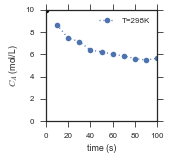

Experiment 1 was at T=308.15K and ran for 100 seconds


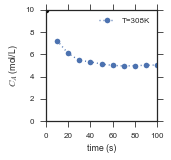

Experiment 2 was at T=323.15K and ran for 100 seconds


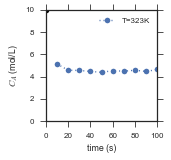

In [4]:
from numpy import array
experiments = [ExperimentData(T=298.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])), 
               ExperimentData(T=308.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036])), 
               ExperimentData(T=323.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])),
              ]

for i,e in enumerate(experiments):
    print("Experiment {} was at T={}K and ran for {} seconds".format(i, e.T, e.times[-1]))
    plot_experiment(e)

In [201]:
ParameterSet = namedtuple('ParameterSet', ['logA', 'Ea', 'dH', 'dS'])

# This is a sensible starting guess for your fitting
starting_guess = ParameterSet(
    logA = 6. , # base-ten logarithm of A in s^-1
    Ea = 45. , # Ea in kJ/mol
    dH = -10. , # ∆H in kJ/mol
    dS = -50.  # ∆S in J/mol/K
    )
# This should end up with your optimized parameters
optimized_parameters = ParameterSet(0,0,0,0)

# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.
standard_errors = ParameterSet(0,0,0,0)

In [203]:
from scipy.integrate import odeint

R = 8.314

temps = [experiments[0].T] * 10 + [experiments[1].T] * 10 + [experiments[2].T] * 10
temps = np.array(temps).flatten()
times = [experiments[0].times] + [experiments[1].times] + [experiments[2].times]
times = np.array(times).flatten()
cA = [experiments[0].cA] + [experiments[1].cA] + [experiments[2].cA]
cA = np.array(cA).flatten()


def ODE(tT,logA,Ea,dH,dS):

    t, T = tT
    points = len(t)
    Ea = Ea * 1e3 #Converting Ea to kJ
    dH = dH * 1e3 #Converting dH to kJ
    cA = np.zeros(points)
    for n in range(points):
        t1 = t[n]
        T1 = T[n]
        R= 8.314
        dG = dH - T * dS
        Ka = np.exp(-dG / (R * T))
        Kc = Ka
        kf = 10 ** logA * np.exp( -Ea / (R * T)) #Converting Ea to kJ
        kr = kf / Kc
        def dCa_dt(cA, t):
            cB = 10. - cA
            rA = kf*cB - kr*cA
            return rA
        solution = scipy.integrate.odeint(dCa_dt, 10., [0,t])
        result=solution[-1,0]
        cA[n]=result
    return cA

tT = np.array([times, temps])
optimal_parameters, covariance = scipy.optimize.curve_fit(ODE,tT,cA,p0=starting_guess,method = 'trf')
#print(tT)
#print(starting_guess)
#print(ODE(np.array([[10],[298]]),7,50,-10,-40))
#print(cA)

ValueError: setting an array element with a sequence.

Ok, now insert some cells to determine the optimized_parameters and their standard_errors.


In [196]:
ParameterSet = namedtuple('ParameterSet', ['logA', 'Ea', 'dH', 'dS'])

# This is a sensible starting guess for your fitting
starting_guess = ParameterSet(
    logA = 6. , # base-ten logarithm of A in s^-1
    Ea = 45. , # Ea in kJ/mol
    dH = -10. , # ∆H in kJ/mol
    dS = -50.  # ∆S in J/mol/K
    )

# This should end up with your optimized parameters
optimized_parameters = ParameterSet(0,0,0,0)


# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.
standard_errors = ParameterSet(0,0,0,0)

optimal_parameters, covariance = scipy.optimize.curve_fit(ODE,tT,cA,p0=starting_guess,method = 'trf')
print(optimal_parameters)
# This should end up with your optimized parameters
#optimized_parameters = ParameterSet(0,0,0,0)

# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.

#SD = np.sqrt(np.diag(covariance))

ValueError: setting an array element with a sequence.

In [132]:
# Finish your notebook with this cell
print(starting_guess)
print(optimized_parameters)
print(standard_errors)

ParameterSet(logA=6.0, Ea=45.0, dH=-10.0, dS=-50.0)
[ -277.40616266  -185.18441475 -2061.16572271 -7691.89753973]
[ inf  inf  inf  inf]
